In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print("Setup completed successfully!")

2025-06-23 17:56:58.821074: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-23 17:57:00.772813: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-23 17:57:02.649154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750697824.151167    6387 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750697824.622475    6387 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750697829.057473    6387 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

TensorFlow version: 2.19.0
Setup completed successfully!


In [3]:
# Load and preprocess data with better error handling
print("Loading and preprocessing data...")

try:
    df = pd.read_csv('../data/processed_data.csv', parse_dates=['date'], index_col='date')
    print(f"✓ Data loaded successfully: {len(df)} rows")
except FileNotFoundError:
    print("❌ File not found. Please check the path to processed_data.csv")
    raise

# Handle missing values
initial_rows = len(df)
df.dropna(inplace=True)
print(f"✓ Removed {initial_rows - len(df)} rows with missing values")

# Add temporal features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Normalize data for neural networks
scaler = MinMaxScaler()
feature_columns = ['Appliances', 'T_out', 'lights', 'RH_1']
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[feature_columns]),
    columns=feature_columns,
    index=df.index
)

print(f"✓ Dataset info:")
print(f"  - Total data points: {len(df)}")
print(f"  - Date range: {df.index.min()} to {df.index.max()}")
print(f"  - Features used: {feature_columns}")
print(f"  - Appliances energy range: {df['Appliances'].min():.2f} - {df['Appliances'].max():.2f} Wh")

Loading and preprocessing data...
✓ Data loaded successfully: 19735 rows
✓ Removed 0 rows with missing values
✓ Dataset info:
  - Total data points: 19735
  - Date range: 2016-01-11 17:00:00 to 2016-05-27 18:00:00
  - Features used: ['Appliances', 'T_out', 'lights', 'RH_1']
  - Appliances energy range: 10.00 - 1080.00 Wh


Creating enhanced data visualizations...


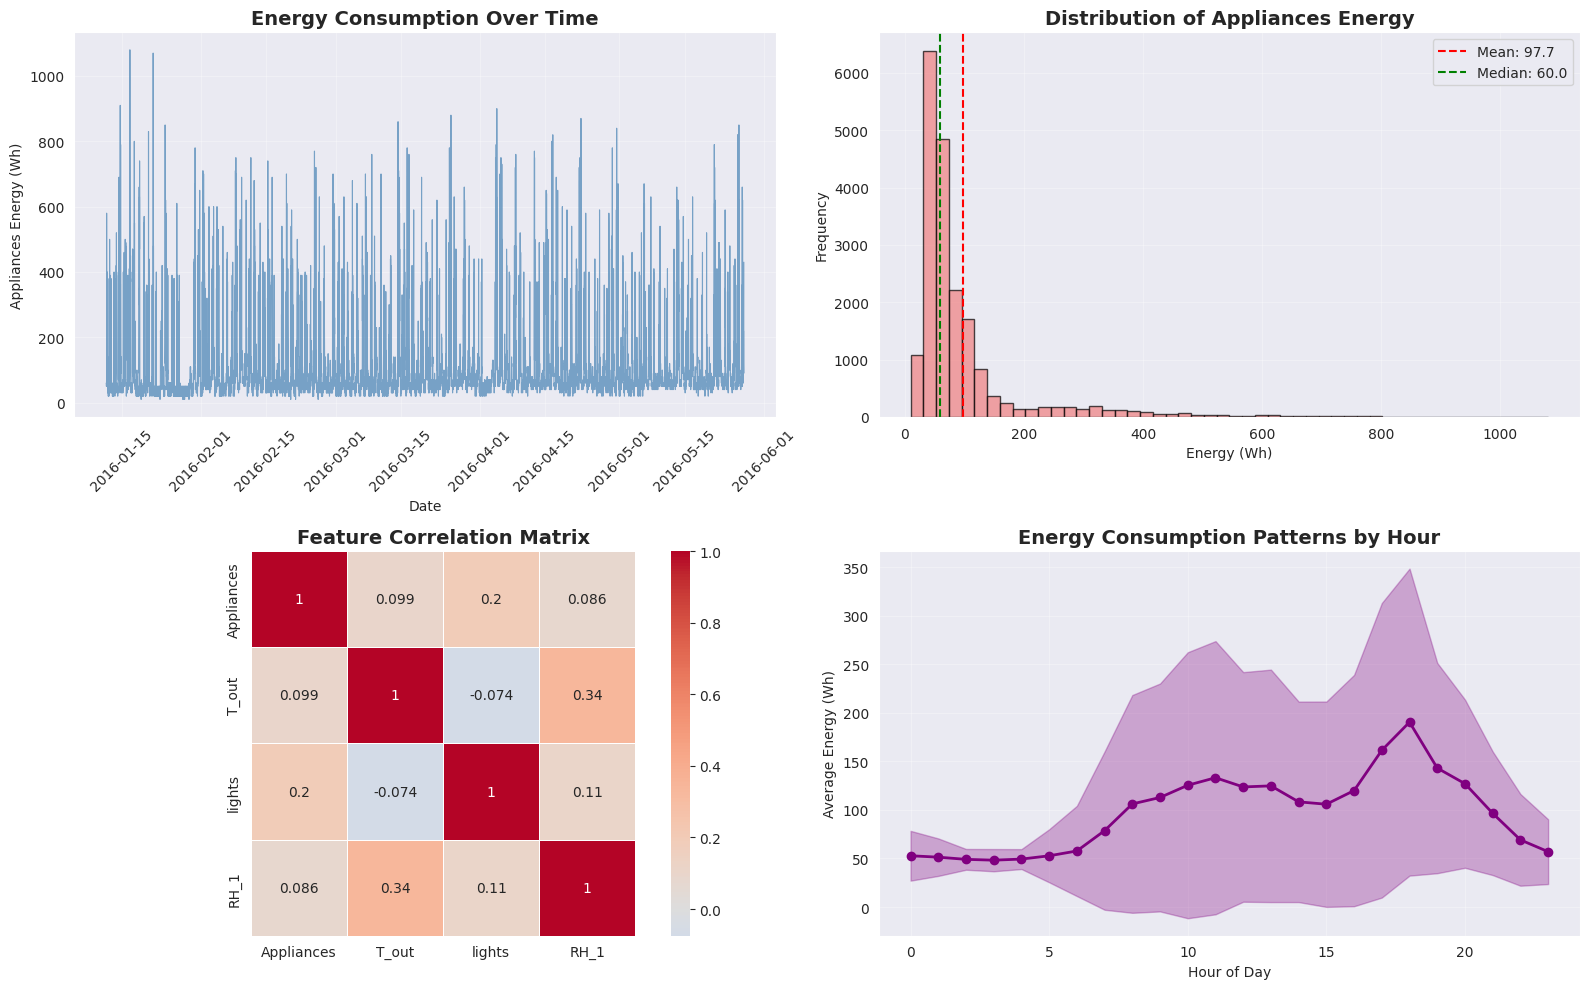


📊 Data Summary:
       Appliances     T_out    lights      RH_1
count    19735.00  19735.00  19735.00  19735.00
mean        97.69      7.41      3.80     40.26
std        102.52      5.32      7.94      3.98
min         10.00     -5.00      0.00     27.02
25%         50.00      3.67      0.00     37.33
50%         60.00      6.92      0.00     39.66
75%        100.00     10.41      0.00     43.07
max       1080.00     26.10     70.00     63.36


In [4]:
# Enhanced data exploration
print("Creating enhanced data visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Energy consumption over time with better styling
axes[0, 0].plot(df.index, df['Appliances'], alpha=0.7, linewidth=0.8, color='steelblue')
axes[0, 0].set_title('Energy Consumption Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Appliances Energy (Wh)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Enhanced distribution with statistics
axes[0, 1].hist(df['Appliances'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(df['Appliances'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["Appliances"].mean():.1f}')
axes[0, 1].axvline(df['Appliances'].median(), color='green', linestyle='--',
                   label=f'Median: {df["Appliances"].median():.1f}')
axes[0, 1].set_title('Distribution of Appliances Energy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Energy (Wh)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Correlation heatmap
corr_matrix = df[feature_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0],
            square=True, linewidths=0.5)
axes[1, 0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Plot 4: Energy consumption patterns by hour
hourly_avg = df.groupby('hour')['Appliances'].agg(['mean', 'std'])
axes[1, 1].plot(hourly_avg.index, hourly_avg['mean'], marker='o', color='purple', linewidth=2)
axes[1, 1].fill_between(hourly_avg.index,
                        hourly_avg['mean'] - hourly_avg['std'],
                        hourly_avg['mean'] + hourly_avg['std'],
                        alpha=0.3, color='purple')
axes[1, 1].set_title('Energy Consumption Patterns by Hour', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average Energy (Wh)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Data Summary:")
print(df[feature_columns].describe().round(2))

In [5]:
# Advanced LSTM Autoencoder with better architecture
def create_sequences(data, window_size=24, step=1):
    """Create sliding window sequences for LSTM training"""
    X = []
    for i in range(0, len(data) - window_size + 1, step):
        X.append(data[i:(i + window_size)])
    return np.array(X)


def build_lstm_autoencoder(window_size, n_features=1, lstm_units=64, dropout_rate=0.2):
    """Build enhanced LSTM autoencoder with better architecture"""
    model = Sequential([
        Input(shape=(window_size, n_features)),

        # Encoder with multiple layers
        LSTM(lstm_units, return_sequences=True, name='encoder_lstm1'),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False, name='encoder_lstm2'),
        Dropout(dropout_rate),

        # Bottleneck
        RepeatVector(window_size, name='repeat_vector'),

        # Decoder with multiple layers
        LSTM(lstm_units // 2, return_sequences=True, name='decoder_lstm1'),
        Dropout(dropout_rate),
        LSTM(lstm_units, return_sequences=True, name='decoder_lstm2'),

        # Output layer
        TimeDistributed(Dense(n_features, activation='linear'), name='output')
    ])

    # Compile with better optimizer settings
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model


# Configuration
WINDOW_SIZE = 24
N_FEATURES = 1
LSTM_UNITS = 64
DROPOUT_RATE = 0.2

print(f"🔧 LSTM Autoencoder Configuration:")
print(f"  - Window size: {WINDOW_SIZE} hours")
print(f"  - LSTM units: {LSTM_UNITS}")
print(f"  - Dropout rate: {DROPOUT_RATE}")
print(f"  - Features: {N_FEATURES} (Appliances only)")

# Prepare sequences
print(f"\n📊 Preparing sequences...")
data_for_sequences = df_scaled['Appliances'].values.reshape(-1, 1)
X = create_sequences(data_for_sequences, WINDOW_SIZE)

print(f"✓ Created {len(X)} sequences")
print(f"✓ Sequence shape: {X.shape}")
print(f"✓ Memory usage: {X.nbytes / (1024 ** 2):.1f} MB")

# Build model
model = build_lstm_autoencoder(WINDOW_SIZE, N_FEATURES, LSTM_UNITS, DROPOUT_RATE)
print(f"\n🏗️ Model Architecture:")
model.summary()

🔧 LSTM Autoencoder Configuration:
  - Window size: 24 hours
  - LSTM units: 64
  - Dropout rate: 0.2
  - Features: 1 (Appliances only)

📊 Preparing sequences...
✓ Created 19712 sequences
✓ Sequence shape: (19712, 24, 1)
✓ Memory usage: 3.6 MB


2025-06-23 17:57:29.770924: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



🏗️ Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_lstm1 (LSTM)            │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm2 (LSTM)            │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm1 (LSTM)            │ (None, 24, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm2 (LSTM)            │ (None, 24, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (TimeDistributed)        │ (None, 24, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

🚀 Starting LSTM Autoencoder Training...
📋 Training Configuration:
  - Epochs: 15
  - Batch size: 32
  - Validation split: 20.0%
  - Training samples: 15769
  - Validation samples: 3942
Epoch 1/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - loss: 0.0063 - mae: 0.0421 - val_loss: 0.0033 - val_mae: 0.0276 - learning_rate: 0.0010
Epoch 2/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0043 - mae: 0.0340 - val_loss: 0.0027 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 3/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.0035 - mae: 0.0310 - val_loss: 0.0023 - val_mae: 0.0229 - learning_rate: 0.0010
Epoch 4/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.0032 - mae: 0.0294 - val_loss: 0.0022 - val_mae: 0.0220 - learning_rate: 0.0010
Epoch 5/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.0029 - mae: 0.0279 - val_loss: 0.0019 - val_mae: 0.0206 - learning_rate: 0.0010
Epoch 6/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - loss: 0.0028 - mae: 0.0278 - val_loss: 

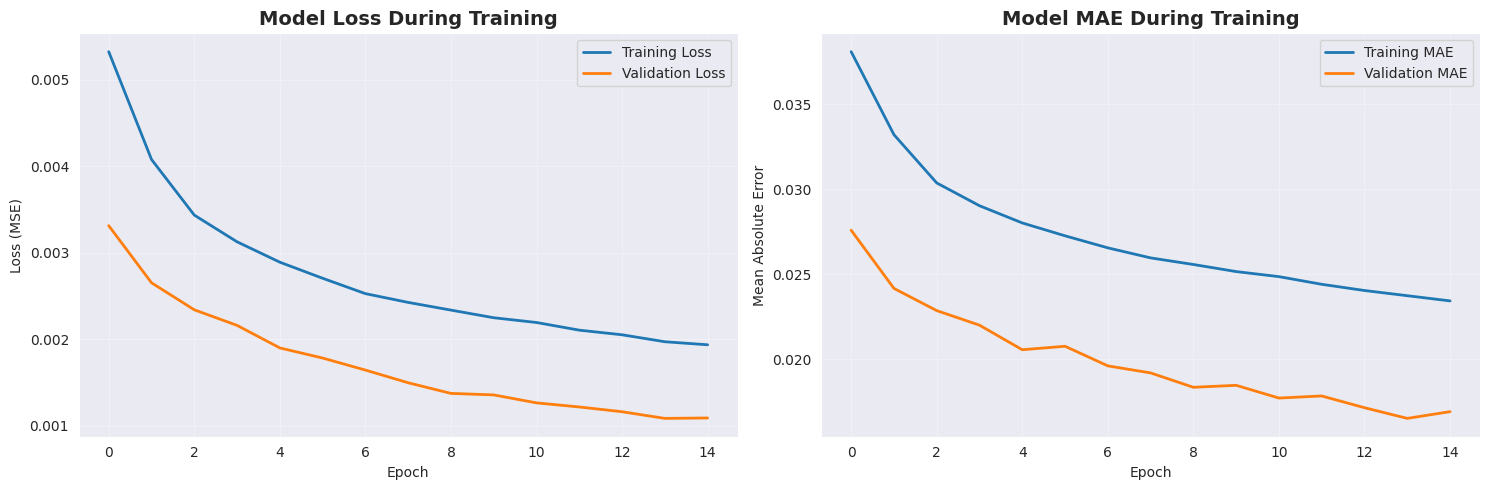

📈 Final Training Metrics:
  - Final training loss: 0.001937
  - Final validation loss: 0.001092
  - Total epochs run: 15


In [6]:
# Enhanced training with proper callbacks and monitoring
print("🚀 Starting LSTM Autoencoder Training...")

# Training configuration
EPOCHS = 15
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Enhanced callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

print(f"📋 Training Configuration:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Validation split: {VALIDATION_SPLIT * 100}%")
print(f"  - Training samples: {int(len(X) * (1 - VALIDATION_SPLIT))}")
print(f"  - Validation samples: {int(len(X) * VALIDATION_SPLIT)}")

# Train the model
history = model.fit(
    X, X,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

print("✅ Training completed!")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE During Training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📈 Final Training Metrics:")
print(f"  - Final training loss: {history.history['loss'][-1]:.6f}")
print(f"  - Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"  - Total epochs run: {len(history.history['loss'])}")

In [7]:
# %%
# Advanced anomaly detection with multiple threshold methods
print(" Performing Advanced Anomaly Detection...")

# Get predictions and calculate reconstruction error
print("Calculating reconstruction errors...")
X_pred = model.predict(X, verbose=0)
reconstruction_error = np.mean(np.square(X_pred - X), axis=(1, 2))

# Multiple threshold methods
thresholds = {
    '95th_percentile': np.percentile(reconstruction_error, 95),
    '99th_percentile': np.percentile(reconstruction_error, 99),
    'mean_plus_2std': np.mean(reconstruction_error) + 2 * np.std(reconstruction_error),
    'mean_plus_3std': np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)
}

print(f" Reconstruction Error Statistics:")
print(f"  - Mean: {np.mean(reconstruction_error):.6f}")
print(f"  - Std: {np.std(reconstruction_error):.6f}")
print(f"  - Min: {np.min(reconstruction_error):.6f}")
print(f"  - Max: {np.max(reconstruction_error):.6f}")
print(f"  - Median: {np.median(reconstruction_error):.6f}")

print(f"\n Threshold Options:")
for name, threshold in thresholds.items():
    anomalies = reconstruction_error > threshold
    anomaly_count = np.sum(anomalies)
    anomaly_percentage = (anomaly_count / len(reconstruction_error)) * 100
    print(f"  - {name}: {threshold:.6f} ({anomaly_count} anomalies, {anomaly_percentage:.2f}%)")

# Use 95th percentile as primary threshold
selected_threshold = thresholds['95th_percentile']
anomalies = reconstruction_error > selected_threshold

print(f"\n✅ Selected threshold: {selected_threshold:.6f} (95th percentile)")
print(f"✅ Detected {np.sum(anomalies)} anomalies ({(np.sum(anomalies) / len(reconstruction_error) * 100):.2f}%)")


 Performing Advanced Anomaly Detection...
Calculating reconstruction errors...
 Reconstruction Error Statistics:
  - Mean: 0.001500
  - Std: 0.002694
  - Min: 0.000011
  - Max: 0.026507
  - Median: 0.000181

 Threshold Options:
  - 95th_percentile: 0.007135 (986 anomalies, 5.00%)
  - 99th_percentile: 0.012695 (198 anomalies, 1.00%)
  - mean_plus_2std: 0.006888 (1068 anomalies, 5.42%)
  - mean_plus_3std: 0.009583 (472 anomalies, 2.39%)

✅ Selected threshold: 0.007135 (95th percentile)
✅ Detected 986 anomalies (5.00%)


 Creating comprehensive visualizations...


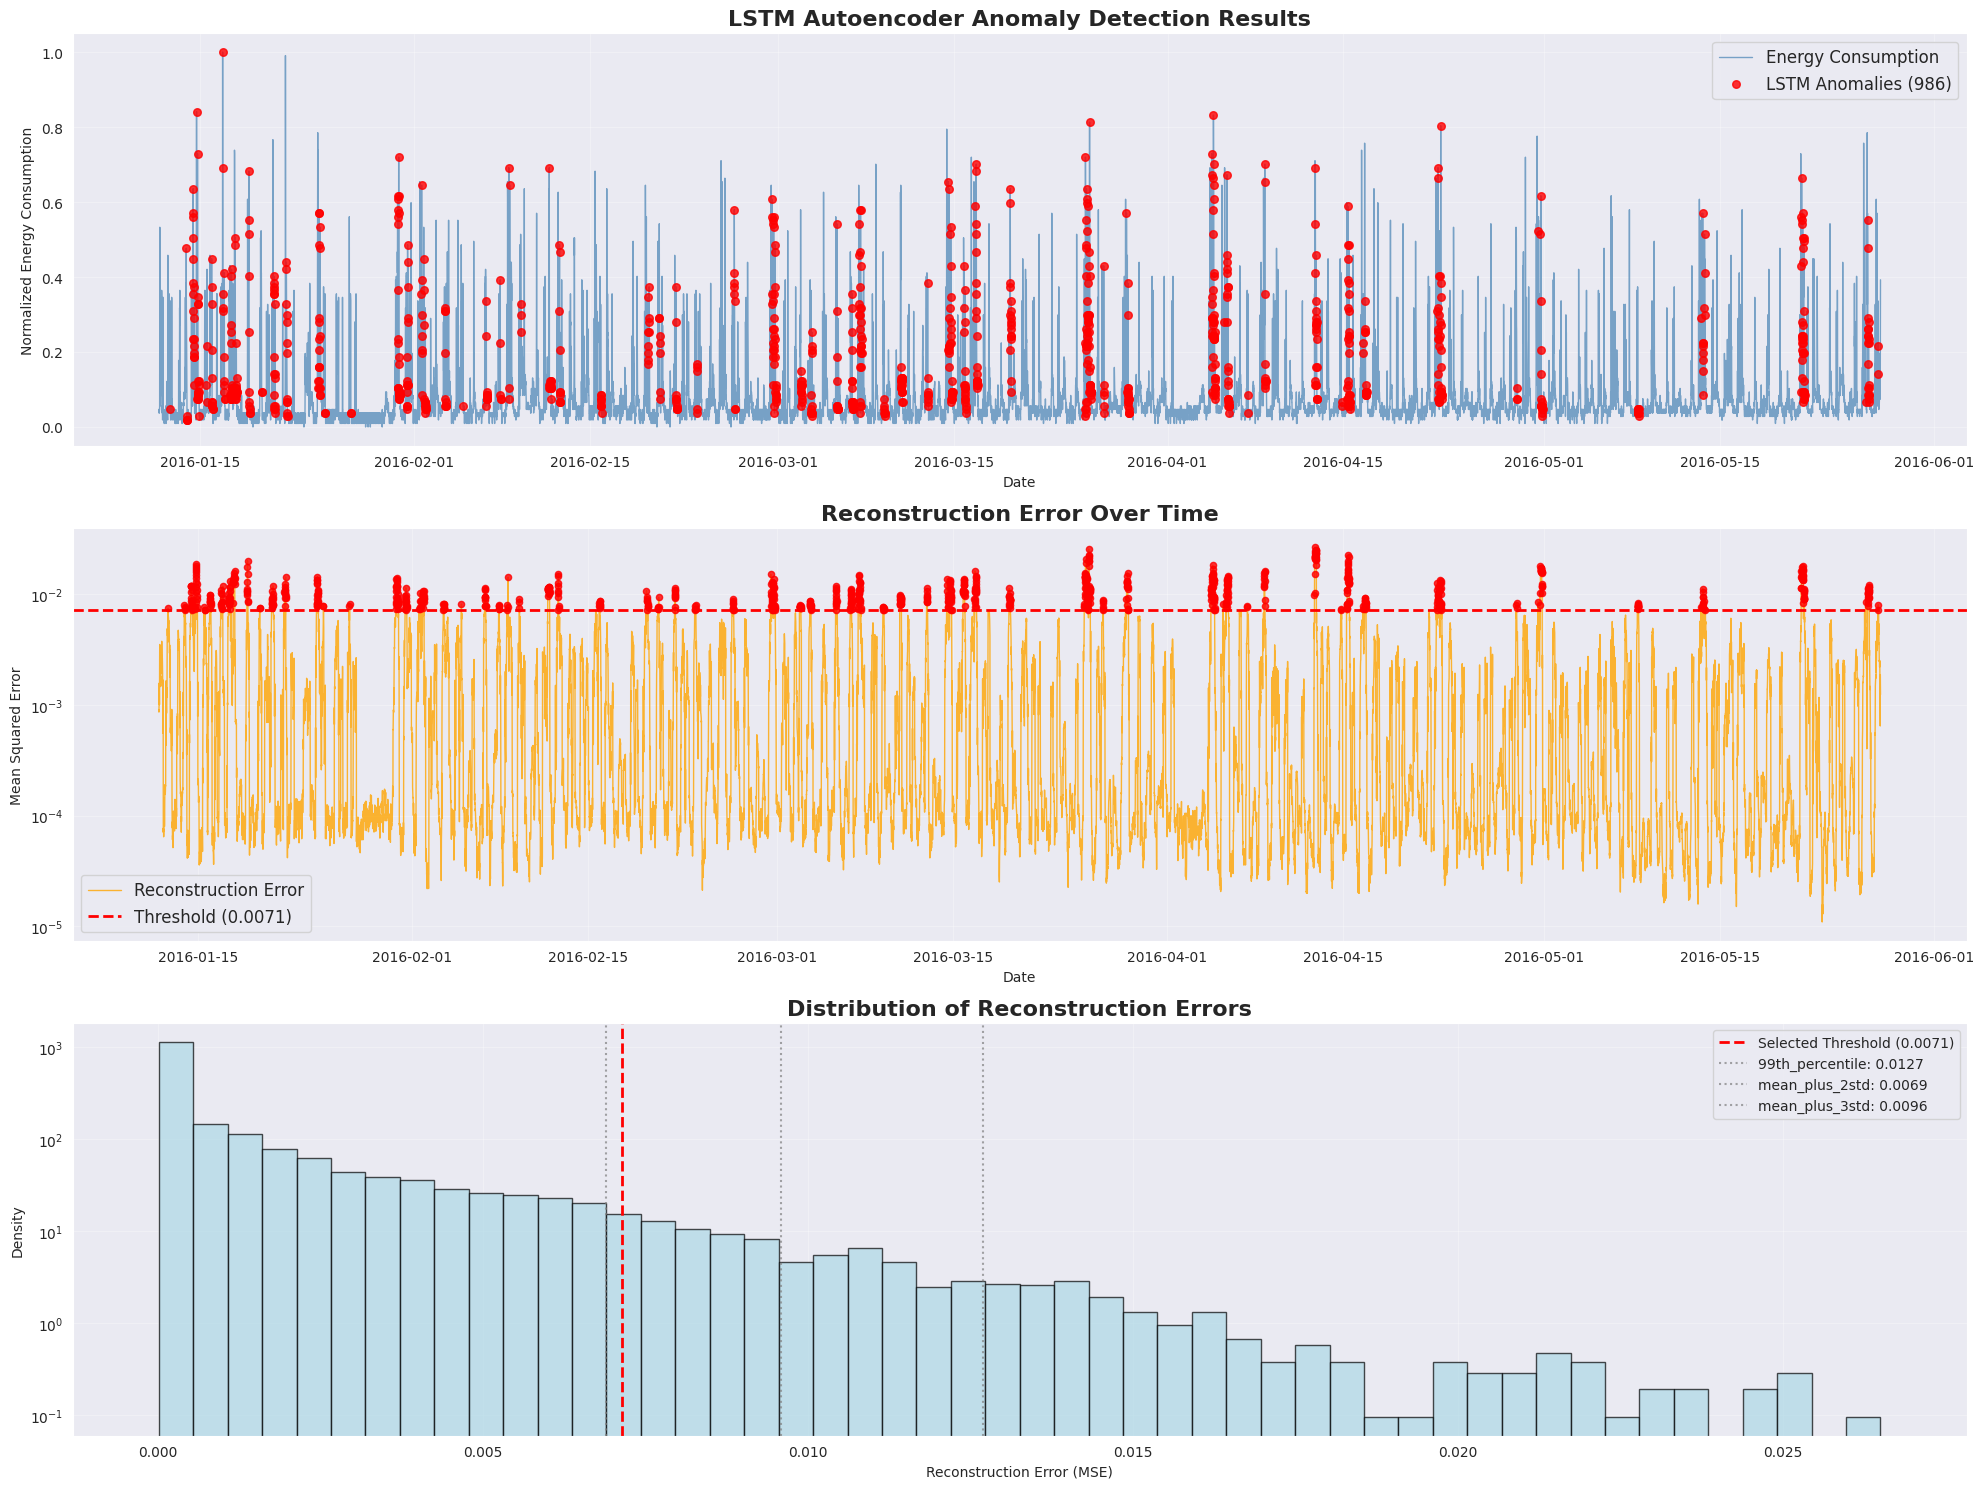

✅ Visualization completed!


In [8]:
# %%
# Enhanced visualization and comprehensive results
print(" Creating comprehensive visualizations...")

# Add results back to dataframe
df_scaled['lstm_error'] = 0.0
df_scaled['lstm_is_anomaly'] = False

# Map results back to original timestamps
error_start_idx = WINDOW_SIZE - 1
df_scaled.iloc[error_start_idx:error_start_idx + len(reconstruction_error),
df_scaled.columns.get_loc('lstm_error')] = reconstruction_error
df_scaled.iloc[error_start_idx:error_start_idx + len(anomalies),
df_scaled.columns.get_loc('lstm_is_anomaly')] = anomalies

# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

# Plot 1: Time series with detected anomalies
axes[0].plot(df_scaled.index, df_scaled['Appliances'],
             label='Energy Consumption', alpha=0.7, linewidth=1, color='steelblue')
anomaly_mask = df_scaled['lstm_is_anomaly']
axes[0].scatter(df_scaled.index[anomaly_mask],
                df_scaled['Appliances'][anomaly_mask],
                color='red', label=f'LSTM Anomalies ({np.sum(anomaly_mask)})',
                s=30, alpha=0.8, zorder=5)
axes[0].set_title('LSTM Autoencoder Anomaly Detection Results', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Normalized Energy Consumption')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Reconstruction error over time
error_mask = df_scaled['lstm_error'] > 0
axes[1].plot(df_scaled.index[error_mask], df_scaled['lstm_error'][error_mask],
             label='Reconstruction Error', alpha=0.8, linewidth=1, color='orange')
axes[1].axhline(y=selected_threshold, color='red', linestyle='--',
                label=f'Threshold ({selected_threshold:.4f})', linewidth=2)
axes[1].scatter(df_scaled.index[anomaly_mask],
                df_scaled['lstm_error'][anomaly_mask],
                color='red', s=20, alpha=0.8, zorder=5)
axes[1].set_title('Reconstruction Error Over Time', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Mean Squared Error')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')  # Log scale for better visualization

# Plot 3: Enhanced error distribution
axes[2].hist(reconstruction_error, bins=50, alpha=0.7, color='lightblue',
             edgecolor='black', density=True)
axes[2].axvline(selected_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Selected Threshold ({selected_threshold:.4f})')
for name, thresh in thresholds.items():
    if name != '95th_percentile':
        axes[2].axvline(thresh, color='gray', linestyle=':', alpha=0.7,
                        label=f'{name}: {thresh:.4f}')
axes[2].set_title('Distribution of Reconstruction Errors', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Reconstruction Error (MSE)')
axes[2].set_ylabel('Density')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print("✅ Visualization completed!")


 Analyzing temporal patterns of detected anomalies...


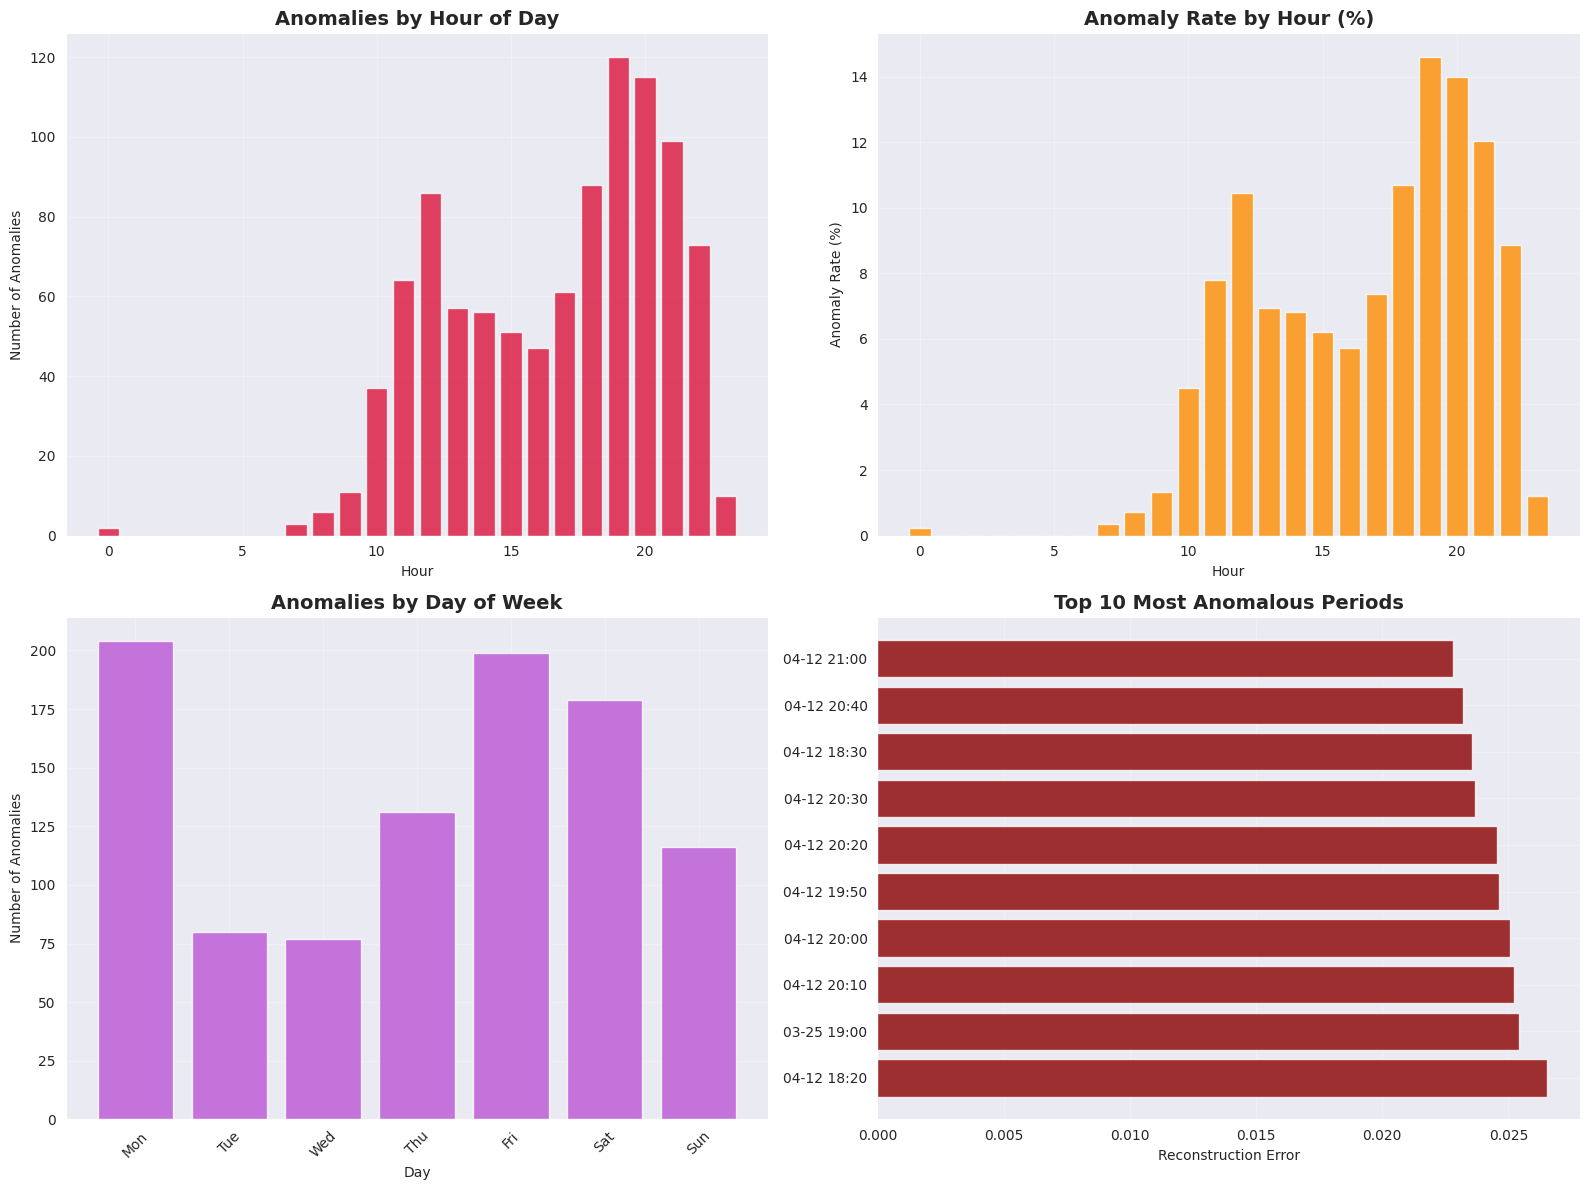

 Temporal Analysis Results:
  - Total anomalies: 986
  - Peak anomaly hour: 19 (14.60% rate)
  - Most active day: Mon (204 anomalies)

 Top 5 Most Anomalous Periods:
  1. 2016-04-12 18:20:00 - Error: 0.026507, Energy: 0.692
  2. 2016-03-25 19:00:00 - Error: 0.025410, Energy: 0.813
  3. 2016-04-12 20:10:00 - Error: 0.025199, Energy: 0.271
  4. 2016-04-12 20:00:00 - Error: 0.025064, Energy: 0.308
  5. 2016-04-12 19:50:00 - Error: 0.024613, Energy: 0.458


In [9]:
# %%
# Comprehensive temporal analysis
print(" Analyzing temporal patterns of detected anomalies...")

# Filter anomalies for analysis
anomaly_data = df_scaled[df_scaled['lstm_is_anomaly']].copy()

if len(anomaly_data) > 0:
    # Add temporal features
    anomaly_data['hour'] = anomaly_data.index.hour
    anomaly_data['day_of_week'] = anomaly_data.index.dayofweek
    anomaly_data['month'] = anomaly_data.index.month

    # Create comprehensive temporal analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Anomalies by hour
    hourly_anomalies = anomaly_data.groupby('hour').size()
    total_by_hour = df_scaled.groupby(df_scaled.index.hour).size()
    hourly_rate = (hourly_anomalies / total_by_hour * 100).fillna(0)

    axes[0, 0].bar(hourly_anomalies.index, hourly_anomalies.values,
                   alpha=0.8, color='crimson')
    axes[0, 0].set_title('Anomalies by Hour of Day', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('Number of Anomalies')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Anomaly rate by hour
    axes[0, 1].bar(hourly_rate.index, hourly_rate.values,
                   alpha=0.8, color='darkorange')
    axes[0, 1].set_title('Anomaly Rate by Hour (%)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel('Anomaly Rate (%)')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Anomalies by day of week
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    daily_anomalies = anomaly_data.groupby('day_of_week').size()
    axes[1, 0].bar([day_names[i] for i in daily_anomalies.index],
                   daily_anomalies.values, alpha=0.8, color='mediumorchid')
    axes[1, 0].set_title('Anomalies by Day of Week', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Day')
    axes[1, 0].set_ylabel('Number of Anomalies')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Top anomalous periods
    top_anomalies = anomaly_data.nlargest(10, 'lstm_error')
    y_pos = np.arange(len(top_anomalies))
    axes[1, 1].barh(y_pos, top_anomalies['lstm_error'], alpha=0.8, color='darkred')
    axes[1, 1].set_yticks(y_pos)
    axes[1, 1].set_yticklabels([f"{idx.strftime('%m-%d %H:%M')}" for idx in top_anomalies.index])
    axes[1, 1].set_title('Top 10 Most Anomalous Periods', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Reconstruction Error')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print(f" Temporal Analysis Results:")
    print(f"  - Total anomalies: {len(anomaly_data)}")
    print(f"  - Peak anomaly hour: {hourly_rate.idxmax()} ({hourly_rate.max():.2f}% rate)")
    print(f"  - Most active day: {day_names[daily_anomalies.idxmax()]} ({daily_anomalies.max()} anomalies)")

    print(f"\n Top 5 Most Anomalous Periods:")
    for i, (idx, row) in enumerate(top_anomalies.head().iterrows(), 1):
        print(f"  {i}. {idx.strftime('%Y-%m-%d %H:%M:%S')} - "
              f"Error: {row['lstm_error']:.6f}, Energy: {row['Appliances']:.3f}")

else:
    print("❌ No anomalies detected for temporal analysis")


In [10]:
# %%
# Save comprehensive results
print(" Saving results and model...")

try:
    # Save the trained model
    model.save('lstm_autoencoder_model.h5')
    print("✅ Model saved as 'lstm_autoencoder_model.h5'")

    # Save comprehensive results
    results_df = df_scaled[['Appliances', 'T_out', 'lights', 'RH_1',
                            'lstm_error', 'lstm_is_anomaly']].copy()
    results_df['timestamp'] = results_df.index
    results_df['original_appliances'] = df['Appliances']  # Include original values
    results_df.to_csv('lstm_anomaly_results.csv', index=False)
    print("✅ Results saved as '../data/lstm_anomaly_results.csv'")

    # Save detailed anomaly information
    if len(anomaly_data) > 0:
        detailed_anomalies = anomaly_data[['Appliances', 'T_out', 'lights', 'RH_1',
                                           'lstm_error', 'hour', 'day_of_week']].copy()
        detailed_anomalies['timestamp'] = detailed_anomalies.index
        detailed_anomalies['original_appliances'] = df.loc[detailed_anomalies.index, 'Appliances']
        detailed_anomalies.to_csv('detailed_lstm_anomalies.csv', index=False)
        print("✅ Detailed anomalies saved as 'detailed_lstm_anomalies.csv'")

    # Save configuration and metrics
    config_metrics = {
        'model_config': {
            'window_size': WINDOW_SIZE,
            'lstm_units': LSTM_UNITS,
            'dropout_rate': DROPOUT_RATE,
            'epochs_run': len(history.history['loss']),
            'batch_size': BATCH_SIZE
        },
        'performance_metrics': {
            'final_train_loss': float(history.history['loss'][-1]),
            'final_val_loss': float(history.history['val_loss'][-1]),
            'threshold_used': float(selected_threshold),
            'anomalies_detected': int(np.sum(df_scaled['lstm_is_anomaly'])),
            'anomaly_percentage': float((np.sum(df_scaled['lstm_is_anomaly']) / len(df_scaled)) * 100)
        }
    }

    import json

    with open('lstm_model_config.json', 'w') as f:
        json.dump(config_metrics, f, indent=2)
    print("✅ Configuration and metrics saved as 'lstm_model_config.json'")

    print(f"\n LSTM Autoencoder Anomaly Detection Completed Successfully!")
    print(f" Final Summary:")
    print(f"  - Model architecture: LSTM Autoencoder with {LSTM_UNITS} units")
    print(f"  - Training epochs: {len(history.history['loss'])}")
    print(f"  - Final validation loss: {history.history['val_loss'][-1]:.6f}")
    print(
        f"  - Anomalies detected: {np.sum(df_scaled['lstm_is_anomaly'])} ({(np.sum(df_scaled['lstm_is_anomaly']) / len(df_scaled) * 100):.2f}%)")
    print(f"  - Threshold used: {selected_threshold:.6f} (95th percentile)")

except Exception as e:
    print(f"❌ Error saving results: {str(e)}")


 Saving results and model...
✅ Model saved as 'lstm_autoencoder_model.h5'
✅ Results saved as '../data/lstm_anomaly_results.csv'
✅ Detailed anomalies saved as 'detailed_lstm_anomalies.csv'
✅ Configuration and metrics saved as 'lstm_model_config.json'

 LSTM Autoencoder Anomaly Detection Completed Successfully!
 Final Summary:
  - Model architecture: LSTM Autoencoder with 64 units
  - Training epochs: 15
  - Final validation loss: 0.001092
  - Anomalies detected: 986 (5.00%)
  - Threshold used: 0.007135 (95th percentile)
